我们开始把 知识用于 实际工程的 优化上, 例如:

- 尽量减少火箭的飞行时间 ;
- 尽量减少桥梁中混凝土的用量或者成本 ;
- 尽量增加 油井的产量 ;

重点介绍一个关于 炮弹的例子 .

- 假设炮弹每次用相同的速度从炮筒中发出, 而发射的角度决定了弹道

In [1358]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from math import sin, cos, pi


def plot_function(f, xmin, xmax, **kwargs):
    ts = np.linspace(xmin, xmax, 1000)
    plt.plot(ts, [f(t) for t in ts], **kwargs)

## 1. 测试模拟器


### 1.1 欧拉方法的模拟器 .


- 欧拉的思路就是按照 很小的时间增量去模拟, 用 小时间窗口的均速运动 去模拟 加速运动.
- 时间增量是 : 0.0.1 s

In [1359]:
def trajectory(theta, speed=20, height=0, dt=0.01, g=-9.81):
    """
    - g 是重力变量, 也就是重力加速度
    """
    vx = speed * cos(pi * theta / 180)
    vz = speed * sin(pi * theta / 180)
    t, x, z = 0, 0, height  # t: 时间, x 是位置 ,z 是高度
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt  # 时间一次是线性增加
        vz += g * dt  # 重力造成 z 方向的加速度稳定 向下是 g(负数) * dt ,
        x += vx * dt  # vx  这段时间内是匀速, 所以 速度 * 时间
        z += vz * dt  #
        ts.append(t)
        xs.append(x)
        zs.append(z)
    return ts, xs, zs

我们 再搞个 辅助的画图函数. 用上面的结果作为输入 转化为 `plot` 需要的从那书

In [1360]:
def plot_trajectories(*trajs, show_seconds=False):
    for traj in trajs:
        xs, zs = traj[1], traj[2]
        plt.plot(xs, zs)
        if show_seconds:
            second_indices = []
            second = 0
            for i, t in enumerate(traj[0]):
                if t >= second:
                    second_indices.append(i)
                    second += 1
            plt.scatter([xs[i] for i in second_indices], [zs[i] for i in second_indices])
    xl = plt.xlim()
    plt.plot(plt.xlim(), [0, 0], c='k')
    plt.xlim(*xl)

    width = 7
    coords_height = (plt.ylim()[1] - plt.ylim()[0])
    coords_width = (plt.xlim()[1] - plt.xlim()[0])
    plt.gcf().set_size_inches(width, width * coords_height / coords_width)

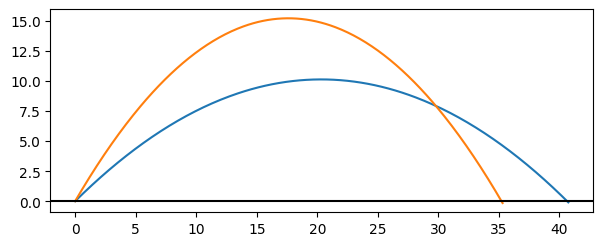

In [1361]:
plot_trajectories(
    trajectory(45),
    trajectory(60)
)

### 1.2 弹道的其他属性

上面的函数 实际上 上包含了 在 z = 0 的时候 x 值,  也就是 `traj[0][-1]` 。

仔细看函数的输出包含的信息是下面按照 index 一一对应的三个 数组.

```
ts, xs, zs
```

很容易得到推论

In [1362]:
def landing_position(traj):  #位置
    return traj[1][-1]


def hang_time(traj):
    return traj[0][-1]  #<1> #滞空时间


def max_height(traj):  # 最大高度
    return max(traj[2])

### 1.3 探索不同的发射角度

我们可以把 上面的 2个函数组合起来 . 例如落地位置 .

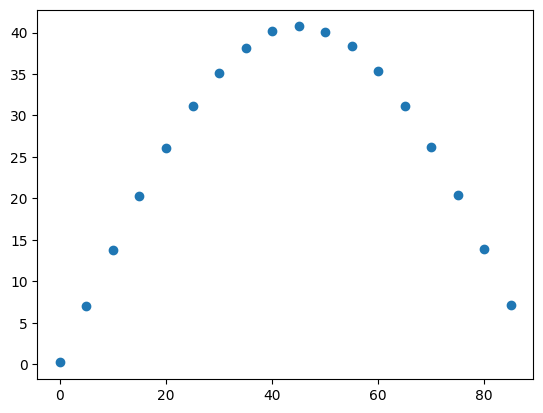

In [1363]:
angles = range(0, 90, 5)
landing_positions = [landing_position(trajectory(theta)) for theta in angles]
## 角度 和 落地位置的点 .
plt.scatter(angles, landing_positions)

### 1.4 exercises

**exec1:** 炮弹以初始高度 为0, 发射角度为 50度, 能飞多远 ?

In [1364]:
landing_position(trajectory(50))

40.10994684444007

**exec2**: 增强 plot_trajectories 函数, 每过 1秒, 画1个大圆点用来表达处时间的流逝 .

上面的函数有个参数 设置 = True 即可 . 可以查看源码 .

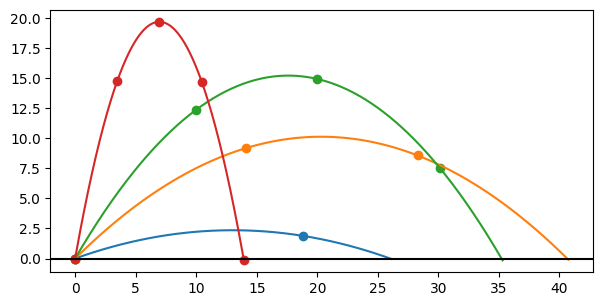

In [1365]:
plot_trajectories(
    trajectory(20),
    trajectory(45),
    trajectory(60),
    trajectory(80),
    show_seconds=True)

**exec3:** 绘制当发射角为 0度 到 180 的飞行时间和角度关系的 散点图, 哪个发射角可以得到最长的飞行时间 ?

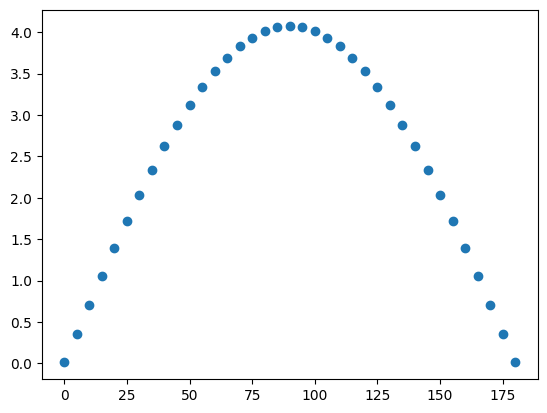

In [1366]:
angles = range(0, 181, 5)
hang_times = [hang_time(trajectory(theta)) for theta in angles]
## 角度 和 落地位置的点 .
plt.scatter(angles, hang_times)

**exec4**: 编写函数 plot_trajectory_metric , 在给定的一组几何上 绘制任何想要的度量结果 .

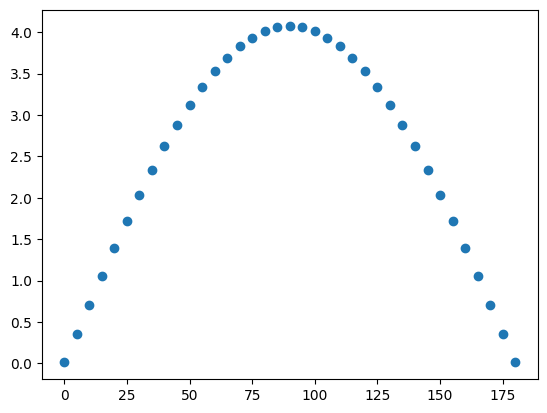

In [1367]:
def plot_trajectory_metric(metric, thetas, **settings):
    """
    本质上是把上面的 封装起来 . 实现一个 高阶函数.
    @param metric 是一个度量函数 上面的 hang_time 等等
    @param thetas 传入的角度 range

    """
    plt.scatter(thetas, [metric(trajectory(theta, **settings)) for theta in thetas])


# 这个例子就是模拟上个小项目的 滞空时间函数
plot_trajectory_metric(hang_time, range(0, 181, 5))

## 2. 计算最佳射程

利用微积分, 可以计算出最大的射程 和 对应的发射角度 .



### 2.1 求炮弹的发射角函数

对于最大距离 其实很简单, 因为 $$v_x$$

一直是相同的, 参数只有1个初始速度和 1个重力加速的 影响 . 问题在于求出时间 .

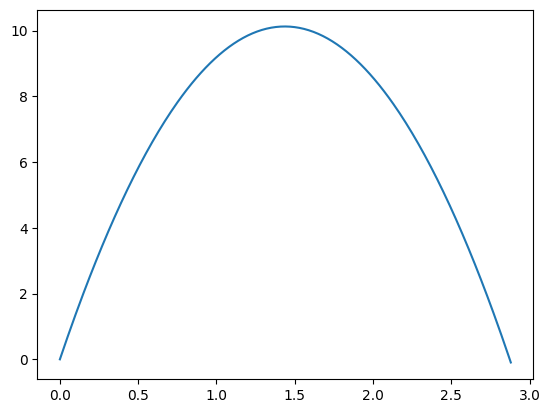

In [1368]:
trj = trajectory(45)
ts, zs = trj[0], trj[2]
plt.plot(ts, zs)  # ts 和 zs 的关系 .

从上图可以看出来, 大约的时间是 2.9 seconds .

我们计算的思路要不直接使用 牛顿公式, 或者 自己

下面开始使用 积分速度变化 .

$$
z^{'}(t) = z^{'}(0) + \int_0^t g \mathrm d(t) = |\vec{v}| \cdot sin(\theta) + gt
$$

再使用上面的速度积分得到位置变化 .

$$
z(t) = z(0) + \int_0^t z^{'} \mathrm d(t) = |\vec{v}| \cdot sin(\theta) \cdot t + \frac {g{t^2}}{2}
$$

我们使用代码构建:

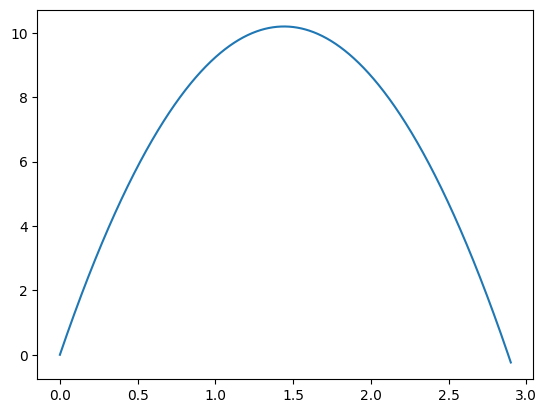

In [1369]:
def z(t, angle):
    return 20 * sin(angle * pi / 180) * t + (-9.81) * t * t / 2


plot_function(lambda t: z(t, 45), 0, 2.9)

于是 时间的计算 就转化为1个简单的求解问题 . 二项式方程 , 求解如下:


$$
r(\theta) =  \frac{-2 * {|\vec{v}|} ^ 2}{g} sin(\theta) cos(\theta)
$$

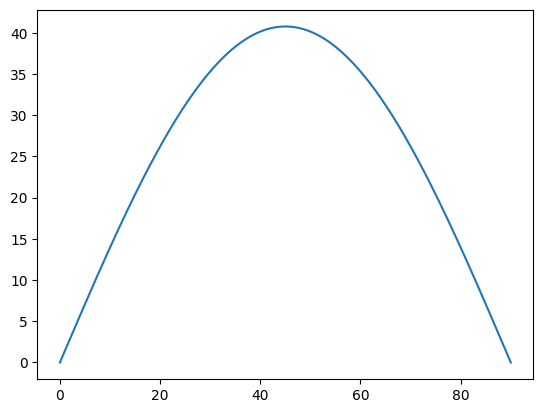

In [1370]:
def r(theta):
    return (-2 * 20 * 20 / -9.81) * sin(theta * pi / 180) * cos(theta * pi / 180)


# 于是我们画出了精确的图 , 发射角度和射程
plot_function(r, 0, 90)

除了准确之外, 这个 微积分公式拥有 更多的优势:

- 欧拉需要低精度的模拟 计算成本非常的高
- 还有的优势 就是这个函数是 平滑的, 可以通过微积分的工具 **求导** 来做更多的事情

### 2.2 求最大射程

通过对导数的简单分析:

- 从0开始增加发射角度， 射程会在一段时间内增大 . 然后减少
- 导数 = 0 的时候, 射程最大 . 因此就是我们的目标角度了 ~

这就是纯代数问题了 . 原始函数是:


$$
r(\theta) =  \frac{-2 * {|\vec{v}|} ^ 2}{g} sin(\theta) cos(\theta)
$$

观察, 其实就是1个简单的三角函数 . 左边的都是定植 .

$$
r^{'}(\theta) =  \frac{-2 * {|\vec{v}|} ^ 2}{g} (cos^2(\theta) - sin^2(\theta)) = \frac{-2 * {|\vec{v}|} ^ 2}{g} cos(2 \theta)
$$

极值要求 导数 = 0 ,所以答案是 45度, 135度的时候 ...

### 2.3 确定最大值和最小值


导数 = 0 是极值的话, 不确定是 max 还是 min, 要分析的话

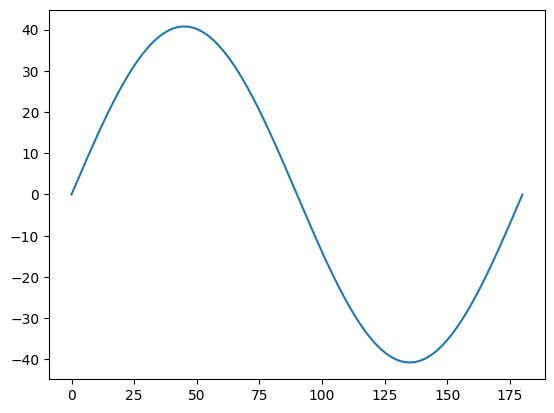

In [1371]:
plot_function(r, 0, 180)

如上图所示. 45 是 max, 135 是 min . (而且注意到都是 局部的， 而不是全局的 max , min)

区别 45 : 先增大后减少 , 135 先减少后增加 .

例如例子:
$$y = x^3 - x$$

观察局部 (-1, 1) 有2个地方导数为0 是极值, 全局的话 是正负无穷 .


还有一种情况 **极值 =0** 不是局部 max 或者 局部 min

例如 $$y = x^3$$

- x =0 导数为0 但是不是机值.

所以 极值 =0 只是个 必要条件 .

### 2.4 exercises

**exec1:** 发射角和对应的最大飞行时长的函数

由于 x 轴的速度固定 .

用距离函数 除一下.

$$
T(\theta) = 2 * {\vec{v}_z} / g = 2 |v|sin(\theta)/g
$$



通过导数 发现 最大值是 90 度, 符合感知,直接 往上发是 最高的 .

## 3. 增强模拟器

最初的参数仅仅是 1个角度,  现在我们在三维空间中发射!. 添加1个参数


### 3.1 添加另1个维度 .

y : 表示炮弹从 x 轴正方向 旋转的角度.

此时水平速度会在 x 和 y 上拆分.

$$
v_x = |\vec{v}| cos(\theta)
$$

转为

$$
v_x = |\vec{v}| cos(\theta) cos(\phi)
$$

In [1372]:
def trajectory3d(theta, phi, speed=20, height=0, dt=0.01, g=-9.81):
    vx = 20 * cos(pi * theta / 180) * cos(pi * phi / 180)
    vy = 20 * cos(pi * theta / 180) * sin(pi * phi / 180)
    vz = 20 * sin(pi * theta / 180)
    t, x, y, z = 0, 0, 0, height
    ts, xs, ys, zs = [t], [x], [y], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        y += vy * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
    return ts, xs, ys, zs

In [1373]:
def plot_trajectory3d(traj):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(7, 7)
    # ax = fig.gca(projection='3d')
    ax.plot(traj[1], traj[2], traj[3])

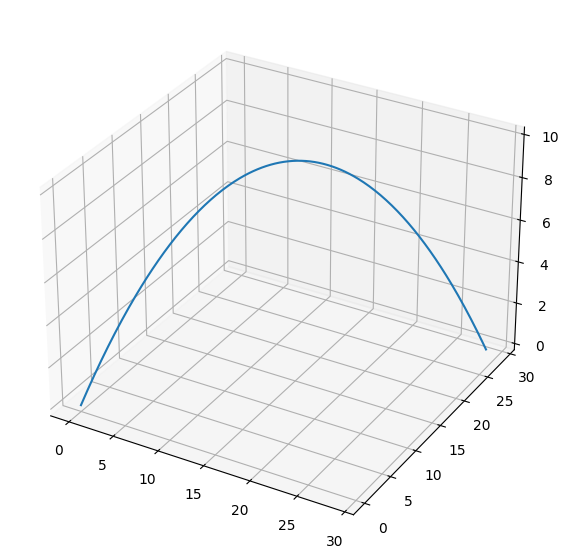

In [1374]:
plot_trajectory3d(trajectory3d(45, 45))

这个参数 对 最大射程角度没有影响.

### 3.2 加入地形参数

周围的 山丘和山谷意味着 不同的位置发射的时候, 炮弹在空间停留的时间不同 .

我们用一个函数来模拟 海拔高度 .

In [1375]:
def flat_ground(x, y):
    # 平坦的地面 每个地方都是海拔0
    return 0


def ridge(x, y):
    return (x ** 2 - 5 * y ** 2) / 2500

由于加入了地形, 我们使用 elevation 来定义地形 . 还是用 欧拉方法来模拟 .

In [1376]:
def trajectory3d(theta, phi, speed=20, height=0, dt=0.01, g=-9.81, elevation=flat_ground):
    vx = speed * cos(pi * theta / 180) * cos(pi * phi / 180)
    vy = speed * cos(pi * theta / 180) * sin(pi * phi / 180)
    vz = speed * sin(pi * theta / 180)
    t, x, y, z = 0, 0, 0, height
    ts, xs, ys, zs = [t], [x], [y], [z]
    while z >= elevation(x, y):
        t += dt
        vz += g * dt
        x += vx * dt
        y += vy * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
    return ts, xs, ys, zs

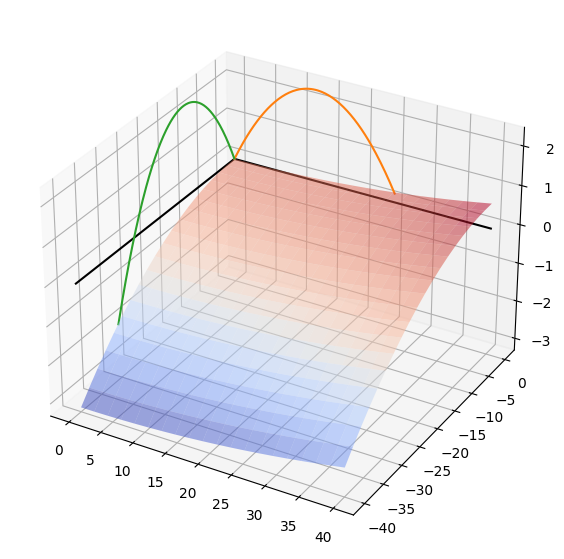

In [1377]:
def plot_trajectories_3d(*trajs, elevation=flat_ground, bounds=None, zbounds=None, shadows=False):
    # fig, ax = plt.gcf(), plt.gca(projection='3d')
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(7, 7)

    if not bounds:
        xmin = min([x for traj in trajs for x in traj[1]])
        xmax = max([x for traj in trajs for x in traj[1]])
        ymin = min([x for traj in trajs for x in traj[2]])
        ymax = max([x for traj in trajs for x in traj[2]])

        padding_x = 0.1 * (xmax - xmin)
        padding_y = 0.1 * (ymax - ymin)
        xmin -= padding_x
        xmax += padding_x
        ymin -= padding_y
        ymax += padding_x

    else:
        xmin, xmax, ymin, ymax = bounds

    plt.plot([xmin, xmax], [0, 0], [0, 0], c='k')
    plt.plot([0, 0], [ymin, ymax], [0, 0], c='k')

    g = np.vectorize(elevation)
    ground_x = np.linspace(xmin, xmax, 20)
    ground_y = np.linspace(ymin, ymax, 20)
    ground_x, ground_y = np.meshgrid(ground_x, ground_y)
    ground_z = g(ground_x, ground_y)
    ax.plot_surface(ground_x, ground_y, ground_z, cmap=cm.coolwarm, alpha=0.5,
                    linewidth=0, antialiased=True)
    for traj in trajs:
        ax.plot(traj[1], traj[2], traj[3])
        if shadows:
            ax.plot([traj[1][0], traj[1][-1]], [traj[2][0], traj[2][-1]], [0, 0], c='gray', linestyle='dashed')

    if zbounds:
        ax.set_zlim(*zbounds)


plot_trajectories_3d(
    trajectory3d(20, 0, elevation=ridge),
    trajectory3d(20, 270, elevation=ridge),
    bounds=[0, 40, -40, 0],
    elevation=ridge)

由于地形的不同 导致 不同的角度发射炮弹  落点和高度都不同 .

我们先做个猜测, 要向炮弹远, 方向应该是 朝下坡方向开, 这是符合直觉的 .

### 3.3 在三维空间中求炮弹的射程

在最新的模拟中， 炮弹虽然是在三维空间中发射的 .

但是轨迹垂直于1个垂直面 .也就是考虑 偏方程, 给定 某个角度的值去思考另1个角度 .

我们的目标是 得到最终的距离函数:

$$
r(\theta, \phi)
$$


炮弹 在时间 t 的高度, 利用之前 二维空间的推论, 完全一样, 不受角度和地形的影响

$$
z(t) = v_z \cdot t  + \frac{1}{2} g{t^2}
$$

再看 高度函数 , 影响参数是 时间t 导致的位置也就是:
$$x_t$$ 和$$y_t$$

$$
x_t = v_xt
$$

$$
y_t = v_yt
$$

也是个线性函数, 在 v 确定的情况下 .

$$
h(x, y) = Bx^2 - Cy^2 其中 B, C 都是常量 .
$$

停止条件是 h(t) = z(t) . 炮弹的高度和海拔高度相同的时候 碰撞就发生爆炸 .

简单的代数推导就可以得到一个 多项式公式

$$
( \frac{g}{2} - B{v_x}^2 + C{v_y}^2 )+ V_zt = 0
$$

感觉二项多项式求解得到 , t 除了 0 另外的值是:

$$
t = \frac{-v_z}  {\frac{g}{2} - B{v_x}^2 + C{v_y}^2}
$$


时间知道了, 而
$$
v_x 和 v_y 都是常数, 是匀速运动
$$

落地的时候的距离是
$$
d =  \frac {-{v_z} \cdot {v_{xy}}} {\frac{g}{2} - B{v_x}^2 + C{v_y}^2}
$$

而其中
$$
v_{xy} = \sqrt{ {v_x}^2 + {v_y}^2}
$$

python 计算公式如下, 哈哈哈 ,出来了 .

In [1378]:
from math import sqrt

B = 0.001  #<1> 山脊形状, 发射速度, 和重力加速度常数
C = 0.005
v = 20
g = -9.81


def velocity_components(v, theta, phi):  #<2> 辅助函数, 求速度三个方向的分量
    vx = v * cos(theta * pi / 180) * cos(phi * pi / 180)
    vy = v * cos(theta * pi / 180) * sin(phi * pi / 180)
    vz = v * sin(theta * pi / 180)
    return vx, vy, vz


def landing_distance(theta, phi):  #<3>
    vx, vy, vz = velocity_components(v, theta, phi)
    v_xy = sqrt(vx ** 2 + vy ** 2)  #<4>
    a = (g / 2) - B * vx ** 2 + C * vy ** 2  #<5>
    b = vz
    landing_time = -b / a  #<6>
    landing_distance = v_xy * landing_time  #<7>
    return landing_distance

我们下面简单 模拟下

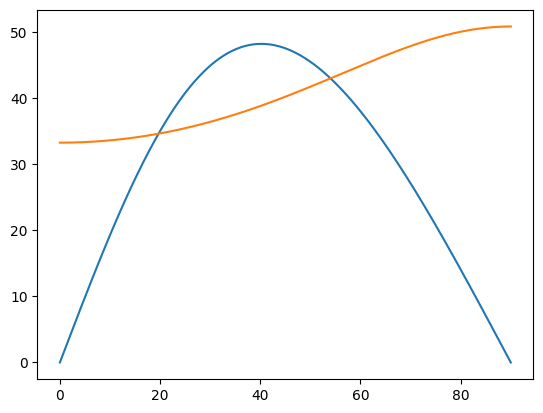

In [1379]:
# 此时 phi 强制 =240度
plot_function(lambda theta: landing_distance(theta, 240), 0, 90)

# 此时 theta 强制 = 30度
plot_function(lambda phi: landing_distance(30, phi), 0, 90)

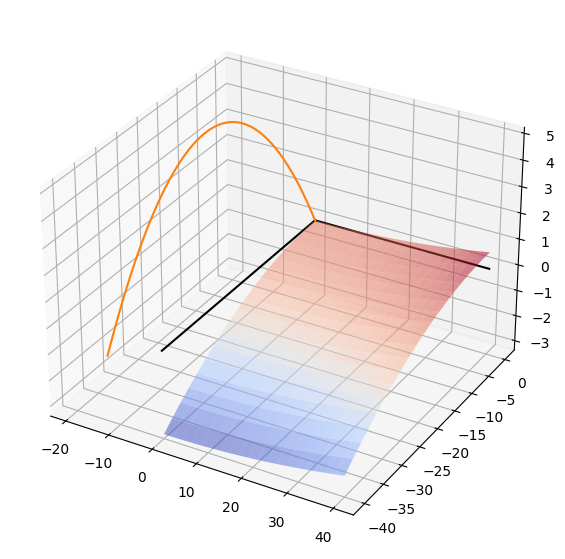

In [1380]:
plot_trajectories_3d(
    trajectory3d(30, 240, elevation=ridge),
    bounds=[0, 40, -40, 0],
    elevation=ridge)

### 3.4 exercises


**exec1**: 明确写出山脊上的射程公式


就是把上面的 速度分量替换下


$$
d(\theta, \phi) = \frac {-{v^2} sin{\theta} cos{\theta}} {\frac{g}{2} + v^2{cos^2(\theta)} \cdot (C{sin^2(\phi)} - B{cos^2(\phi)})}
$$

**exec2:** 加入额外的复杂参数, 基于阻力的 加速度 .

In [1381]:
def trajectory3d(theta, phi, speed=20, height=0, dt=0.01, g=-9.81, elevation=flat_ground, drag=0):
    vx = speed * cos(pi * theta / 180) * cos(pi * phi / 180)
    vy = speed * cos(pi * theta / 180) * sin(pi * phi / 180)
    vz = speed * sin(pi * theta / 180)
    t, x, y, z = 0, 0, 0, height
    ts, xs, ys, zs = [t], [x], [y], [z]
    while z >= elevation(x, y):
        t += dt
        vx -= (drag * vx) * dt
        vy -= (drag * vy) * dt
        vz += (g - (drag * vz)) * dt
        x += vx * dt
        y += vy * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
    return ts, xs, ys, zs

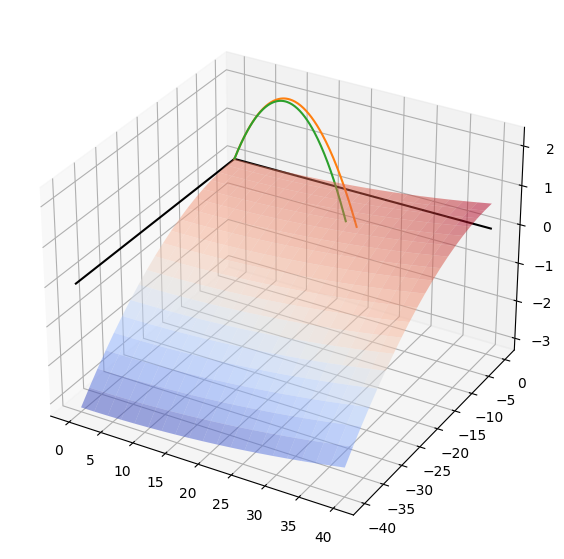

In [1382]:
plot_trajectories_3d(
    trajectory3d(20, -20, elevation=ridge),
    trajectory3d(20, -20, elevation=ridge, drag=0.1),
    bounds=[0, 40, -40, 0],
    elevation=ridge)

从 图中可以看出 有阻力的 射程不如 没有阻力的 射程

## 4. 梯度上升技术

上面的图还是基于 欧拉方式去模拟 .

下面我们要结合之前的 标量势能场知识来分析 .


### 4.1 绘制射程和参数的 heatmap

In [1383]:
def scalar_field_heatmap(f, xmin, xmax, ymin, ymax, xsteps=100, ysteps=100):
    fig = plt.figure()
    fig.set_size_inches(7, 7)

    fv = np.vectorize(f)

    X = np.linspace(xmin, xmax, xsteps)
    Y = np.linspace(ymin, ymax, ysteps)
    X, Y = np.meshgrid(X, Y)

    # https://stackoverflow.com/a/54088910/1704140
    z = fv(X, Y)

    #     # x and y are bounds, so z should be the value *inside* those bounds.
    #     # Therefore, remove the last value from the z array.
    #     z = z[:-1, :-1]
    #     z_min, z_max = -z.min(), z.max()

    fig, ax = plt.subplots()

    c = ax.pcolormesh(X, Y, z, cmap='plasma')
    # set the limits of the plot to the limits of the data
    ax.axis([X.min(), X.max(), Y.min(), Y.max()])
    fig.colorbar(c, ax=ax)

<Figure size 700x700 with 0 Axes>

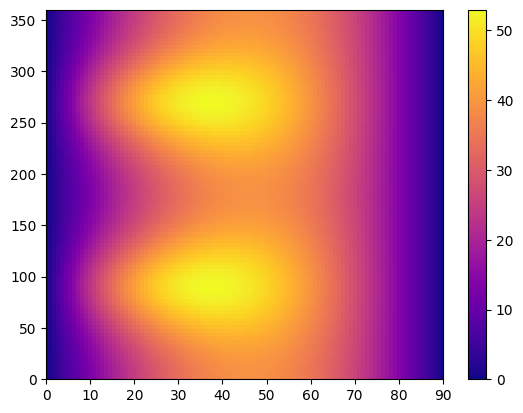

In [1384]:
scalar_field_heatmap(landing_distance, 0, 90, 0, 360)

- 下面的坐标轴是: 角度 theta
- 左边的坐标轴是: 角度 phi
- 右边的坐标轴是: 射程值, 反映的是热度

而亮度代表了最大值 . 在2个中心发现贼亮. 大概是下面的2个值.

- theta = 40 , phi = 90
- theta = 40 , phi = 270


### 4.2 射程函数的梯度 .


类似使用单变量函数的导数来求最大值 .

可以用梯度, 也就是导数的向量场 来求极值 .


$$
{\bigtriangledown}r(\theta, \phi)
$$



In [1385]:
def plot_scalar_field(f, xmin, xmax, ymin, ymax, xsteps=100, ysteps=100, c=None, cmap=cm.coolwarm, alpha=1,
                      antialiased=False):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(7, 7)

    fv = np.vectorize(f)

    # Make data.
    X = np.linspace(xmin, xmax, xsteps)
    Y = np.linspace(ymin, ymax, ysteps)
    X, Y = np.meshgrid(X, Y)
    Z = fv(X, Y)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, color=c, alpha=alpha,
                           linewidth=0, antialiased=antialiased)

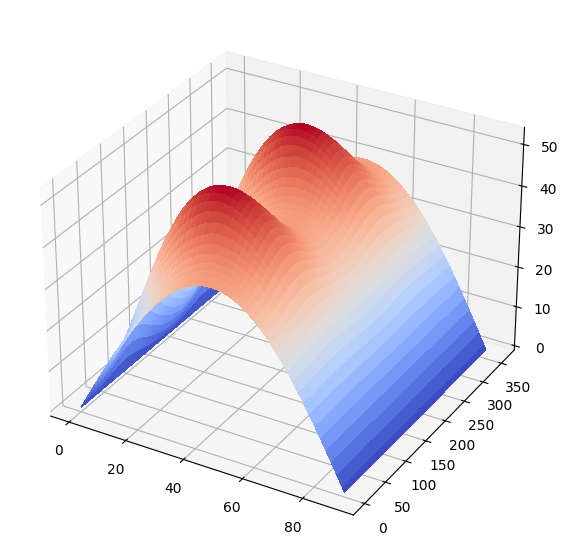

In [1386]:
plot_scalar_field(landing_distance, 0, 90, 0, 360)

我们用 二维的思路扩展到这里来.

- 二维是 斜率 =0 平的.
- 三维其实也一样. 上图平的有2点. 那2个点有特征.
    - 2个偏导数 = 0

$$
\bigtriangledown{r(\theta, \phi)} = (0, 0)
$$


利用纯代数方法, 是非常麻烦的 .可以在练习中计算 .

而有一种巧妙的方法, 非常有启发性, 沿着图片的近似梯度 上坡 直到最高点. 不需要任何的代数运算 .

有一个观点需要回顾: 梯度 =0 不意味着是最大值  . 上面2个坡的中间有个点 其实也是平的, 同样也不是 极值 .


这个点 并非毫无意义, 说明当 phi = 180度 的时候 最佳的 theta 角度. 最佳的上坡方向. 这种点 称为 鞍点:
- 函数相对一个变量 最大化
- 相对另一个变量 最小化 .

这个名称 是因为确实很像马鞍 .


同样, 这里也不证明, 如何识别最大值 最小值 鞍点 或者其他 梯度 =0 的做法.

要注意的是: 随着维度的增加  有奇怪的方式把 图变平 .

### 4.3 利用梯度寻找 上坡方向

梯度的方向告诉我们, 函数在哪个地方增加的最快, 如果这个方向跳到一个新的点 . 我们在朝着最大值 的方向移动 .

这个过程称为 : **梯度上升** . 很容易用代码实现.

**第一步** 是要近似的计算任意一点的梯度, 这个可以用 代数算, 但是很容易用 `python` 去流氓模拟 .

In [1387]:
def secant_slope(f, xmin, xmax):  #<1> 求 x在 xmin 和 xmax 之间的割线的 f(x) 的斜率
    return (f(xmax) - f(xmin)) / (xmax - xmin)


def approx_derivative(f, x, dx=1e-6):  #<2> 利用 6位小数点去近似 .
    return secant_slope(f, x - dx, x + dx)

下面近似的去算 近似偏导数:

对于 f(x, y) 在 (x0, y0)的偏导数.

- partial_x : 固定 y = y0 . 计算 f(x, y0) 在 x = x0 的斜率
- partial_y : 固定 x = x0 . 计算 f(x0, y) 在 y = y0 的斜率

In [1388]:
def approx_gradient(f, x0, y0, dx=1e-6):
    partial_x = approx_derivative(lambda x: f(x, y0), x0, dx=dx)
    partial_y = approx_derivative(lambda y: f(x0, y), y0, dx=dx)
    return partial_x, partial_y

In [1389]:
def landing_distance_gradient(theta, phi):
    return approx_gradient(landing_distance, theta, phi)

和所有的梯度一样, 我们定义了1个向量场: 由空间中每个点上的向量构成 .

这种情况下, 向量场表明了 r 在任意点 (theta, phi) 的最大增量向量 .

<Figure size 700x700 with 0 Axes>

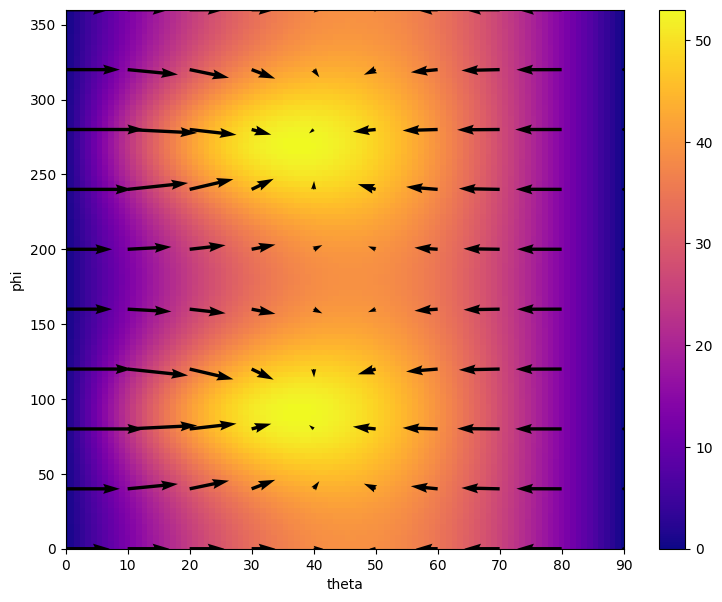

In [1390]:
def draw_arrow(tip, tail, color='k'):
    tip_length = (plt.xlim()[1] - plt.xlim()[0]) / 20.
    length = sqrt((tip[1] - tail[1]) ** 2 + (tip[0] - tail[0]) ** 2)
    new_length = length - tip_length
    new_y = (tip[1] - tail[1]) * (new_length / length)
    new_x = (tip[0] - tail[0]) * (new_length / length)
    plt.gca().arrow(tail[0], tail[1], new_x, new_y,
                    head_width=tip_length / 1.5,
                    head_length=tip_length / 2,
                    fc=color, ec=color)


def plot_vector_field(f, xmin, xmax, ymin, ymax, xsteps=10, ysteps=10, color='k'):
    X, Y = np.meshgrid(np.linspace(xmin, xmax, xsteps), np.linspace(ymin, ymax, ysteps))
    U = np.vectorize(lambda x, y: f(x, y)[0])(X, Y)
    V = np.vectorize(lambda x, y: f(x, y)[1])(X, Y)
    plt.quiver(X, Y, U, V, color=color)
    fig = plt.gcf()


scalar_field_heatmap(landing_distance, 0, 90, 0, 360)
plot_vector_field(landing_distance_gradient, 0, 90, 0, 360, xsteps=10, ysteps=10, color='k')
plt.xlabel('theta')
plt.ylabel('phi')
plt.gcf().set_size_inches(9, 7)

这仿佛给我们不断指明 前进的方向一样, 梯度上升了 引领着你达到最大的值 .

如果把图放大可以看的更清楚 .

<Figure size 700x700 with 0 Axes>

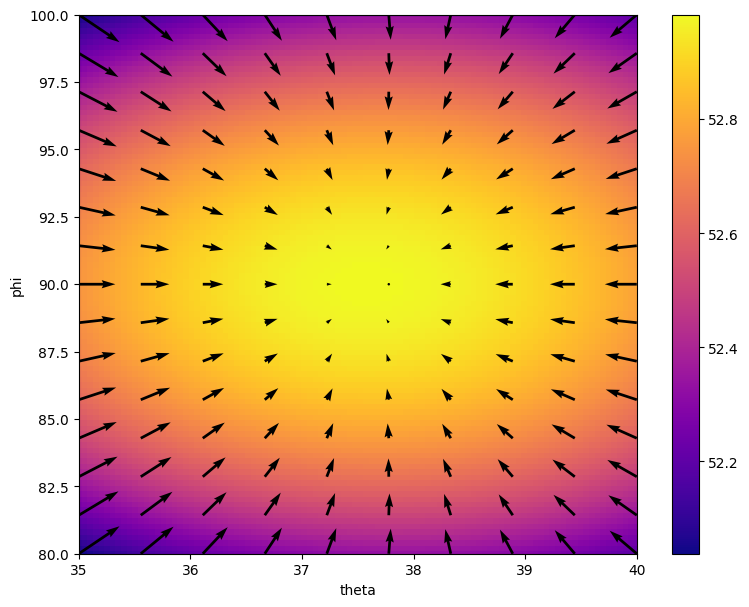

In [1391]:
scalar_field_heatmap(landing_distance, 35, 40, 80, 100)
plot_vector_field(landing_distance_gradient, 35, 40, 80, 100, xsteps=10, ysteps=15, color='k')
plt.xlabel('theta')
plt.ylabel('phi')
plt.gcf().set_size_inches(9, 7)

### 4.4 实现梯度上升法

梯度上升算法的输入是 需要最大化的函数 和一个起点位置 .

选择任何的点开始, 我们跟着梯度场 就能达到最大值 .

算法的实现中:

- 首先计算起点的梯度 .
- 然后和起点的位置相加, 就得到了新点
- 重复上面的过程 我们就越来越接近了

最终， 当接近1个最大值, 梯度会跟着图形 达到一个高点 而接近 0 .

- 当接近 0 的时候, 我们认为没有上坡路可以走了
- 算法可以终止.

因此 我们可以传入1个 近似算法的 容错值 `tolerance` , 表示应该遵循的最小梯度值 .

- 如果梯度小于容错, 就可以基本上认为 图是平的, 已经达到了函数的最大值 .

In [1392]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from chapters.internal.tools.vectors import length


def gradient_ascent(f, xstart, ystart, tolerance=1e-6):
    """
    @param f : 梯度向量场
    @param xstart : 起始点 x
    @param ystart : 起始点 y
    """
    x = xstart
    y = ystart
    grad = approx_gradient(f, x, y)  # 计算此时的梯度向量
    while length(grad) > tolerance:  # 如果梯度向量的 长度 > 容错
        x += grad[0]
        y += grad[1]
        grad = approx_gradient(f, x, y)  # 按照梯度的方向前进
    return x, y


In [1393]:
gradient_ascent(landing_distance, 36, 83)

(37.58114754400058, 89.9999252295876)

配合之前的热图 可以肉眼 发现 非常的接近了 .

为了更好的了解这个算法的 原理 我们可以在平面上 跟踪踪迹, 把路上的点都画出来.

In [1394]:
def gradient_ascent_points(f, xstart, ystart, tolerance=1e-6):
    x = xstart
    y = ystart
    xs, ys = [x], [y]
    grad = approx_gradient(f, x, y)
    while length(grad) > tolerance:
        x += grad[0]
        y += grad[1]
        grad = approx_gradient(f, x, y)
        xs.append(x)
        ys.append(y)
    return xs, ys

# 这个值就是一路的值
# gradient_ascent_points(landing_distance, 36, 83)

把值加入热点图 就可以观察到上升路径

<Figure size 700x700 with 0 Axes>

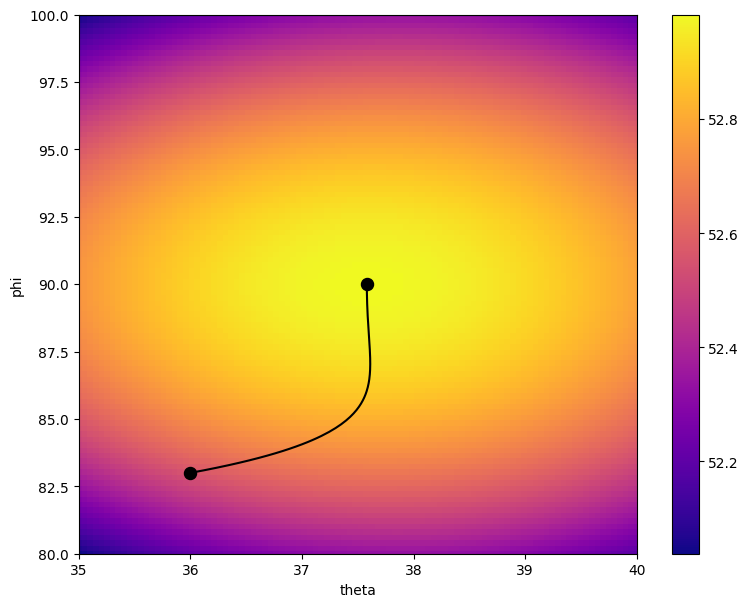

In [1395]:
scalar_field_heatmap(landing_distance, 35, 40, 80, 100)
plt.scatter([36, 37.58114751557887], [83, 89.99992616039857], c='k', s=75)
plt.plot(*gradient_ascent_points(landing_distance, 36, 83), c='k')
plt.xlabel('theta')
plt.ylabel('phi')
plt.gcf().set_size_inches(9, 7)

有趣的是, 由于有多个最大值, 路径取决于最开始 起点的选择.

- 如果 起点接近 phi = 90度 ， 就很可能达到前面计算的最大值 ;
- 如果 起点接近 phi = 270度 ， 就是另外的一个值 ;

In [1396]:
# 梯度上升找到的最大值
landing_distance(37.58114751557887, 89.99992616039857)

52.98310689354378

后续的机器学习程序, 我们将继续依靠梯度来优化函数, 具体来说。我们可以选择相反的方向， 也就是 **梯度下降** .

- 探索参数空间 ， 得到函数的最小值 ;
- 因为梯度上升和梯度下降可以自动执行 .

这2种方法 可以让机器自己学习问题的 最优解 .

### 4.5 exercises


**exec1:** 在热图上, 同时绘制 20个随机点的梯度上升路径 . 所有的路径应该都是 2个终点中的 1个 .

<Figure size 700x700 with 0 Axes>

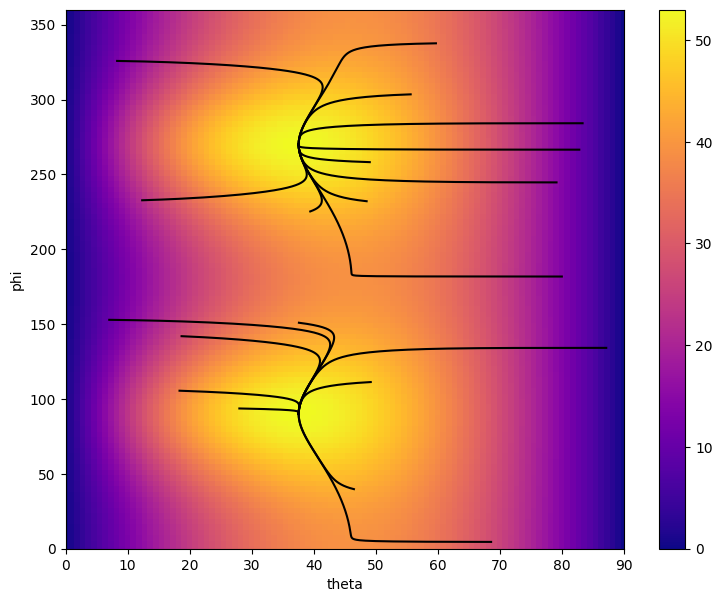

In [1397]:
scalar_field_heatmap(landing_distance, 0, 90, 0, 360)
plt.xlabel('theta')
plt.ylabel('phi')
gap = gradient_ascent_points(landing_distance, 60, 190, 1000)

from random import uniform

for x in range(0, 20):
    gap = gradient_ascent_points(landing_distance, uniform(0, 90), uniform(0, 360))
    plt.plot(*gap, c='k')
plt.gcf().set_size_inches(9, 7)

**exec2**: 梯度的单位可以改变 .

In [ ]:
def gradient_ascent_points(f, xstart, ystart, rate=1, tolerance=1e-6):
    x = xstart
    y = ystart
    xs, ys = [x], [y]
    grad = approx_gradient(f, x, y)
    while length(grad) > tolerance:
        x += rate * grad[0]
        y += rate * grad[1]
        grad = approx_gradient(f, x, y)
        xs.append(x)
        ys.append(y)
    return xs, ys

In [ ]:
def count_ascent_steps(f, x, y, rate=1):
    gap = gradient_ascent_points(f, x, y, rate=rate)
    print(gap[0][-1], gap[1][-1])
    return len(gap[0])

当 rate = 1.5 原来的 855 布会减少为 568 步.

但是这个值太大有问题, 可能步子太大迈过了答案:

- 运气好会折回来， 例如 20
- 运气差 , 梯度上升不会收敛， 因此每次都超过了 最大值, 会无限跳 .